# Afro-MNIST with SciKit-Learn and skorch

In [ ]:
import subprocess

# Installation on Google Colab
try:
    import google.colab
    subprocess.run(['python', '-m', 'pip', 'install', 'skorch' , 'torch'])
except ImportError:
    pass

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

## Loading Data

In [ ]:
!gdown 1GwzlZh15WOwEPcadkn0DHRbiQH9FuQzr

Downloading...
From (original): https://drive.google.com/uc?id=1GwzlZh15WOwEPcadkn0DHRbiQH9FuQzr
From (redirected): https://drive.google.com/uc?id=1GwzlZh15WOwEPcadkn0DHRbiQH9FuQzr&confirm=t&uuid=1c67fae0-bb9d-47c8-b40f-6f4316fdea67
To: /content/Afro-MNIST.zip
100% 108M/108M [00:01<00:00, 73.4MB/s]


In [ ]:
!unzip Afro-MNIST.zip

Archive:  Afro-MNIST.zip
  inflating: Ethiopic/Ethiopic_MNIST_X_test.npy  
  inflating: Ethiopic/Ethiopic_MNIST_X_train.npy  
  inflating: Ethiopic/Ethiopic_MNIST_y_test.npy  
  inflating: Ethiopic/Ethiopic_MNIST_y_train.npy  
  inflating: NKo/NKo_MNIST_X_test.npy  
  inflating: NKo/NKo_MNIST_X_train.npy  
  inflating: NKo/NKo_MNIST_y_test.npy  
  inflating: NKo/NKo_MNIST_y_train.npy  
  inflating: Osmanya/Osmanya_MNIST_X_test.npy  
  inflating: Osmanya/Osmanya_MNIST_X_train.npy  
  inflating: Osmanya/Osmanya_MNIST_y_test.npy  
  inflating: Osmanya/Osmanya_MNIST_y_train.npy  
  inflating: Vai/Vai_MNIST_X_test.npy  
  inflating: Vai/Vai_MNIST_X_train.npy  
  inflating: Vai/Vai_MNIST_y_test.npy  
  inflating: Vai/Vai_MNIST_y_train.npy  


In [ ]:
cd Ethiopic

/content/Ethiopic


In [ ]:
X_train = np.load("Ethiopic_MNIST_X_train.npy")
y_train = np.load("Ethiopic_MNIST_y_train.npy").astype('int64')
X_test  = np.load("Ethiopic_MNIST_X_test.npy")
y_test  = np.load("Ethiopic_MNIST_y_test.npy").astype('int64')
img_rows, img_cols = 28, 28

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols)
input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [ ]:
X_train[0].shape, X_test[0].shape

((28, 28), (28, 28))

In [ ]:
X_train = X_train.reshape((X_train.shape[0], 28*28))
X_test = X_test.reshape((X_test.shape[0], 28*28))

### Print a selection of training images and their labels

In [ ]:
def plot_example(X, y, n=5):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:n].reshape(n, 28, 28), y[:n])):
        plt.figure(figsize=(1.5 * n, 1.5 * n))
        plt.subplot(1, n, 1 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

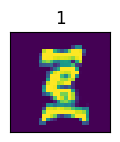

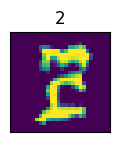

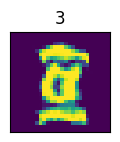

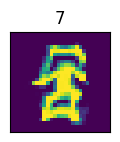

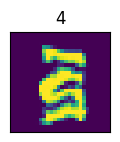

In [ ]:
plot_example(X_train, y_train)

## Build Neural Network with PyTorch

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from skorch import NeuralNetClassifier

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x, eval=False):

        outputs = []
        x = x.reshape((x.shape[0], 1, 28, 28))

        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        outputs.append(x)
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        outputs.append(x)

        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))

        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)

        Ts = None
        layers = None
        layer_num = 0
        if eval:
          for X in outputs:
            X = X.reshape((X.shape[0], np.prod(X.shape) // X.shape[0]))
            Ts = torch.cat((Ts, X), 1) if Ts is not None else X
            l = torch.ones_like(X) * layer_num
            layers = torch.cat((layers, l), 1) if layers is not None else l
            layer_num += 1
          return x, Ts, layers

        return x


In [ ]:

torch.manual_seed(0)

module = Cnn()
cnn = NeuralNetClassifier(
    module,
    max_epochs=3,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

In [ ]:
adversaries_x = torch.tensor(X_test).to(device)
adversaries_y = torch.tensor(y_test).to(device)
epsilon = 10 / 255

In [ ]:
step = 500
for i in range(10):
  adversaries_x = adversaries_x.to(device)
  cnn.fit(adversaries_x, adversaries_y)
  loss = nn.CrossEntropyLoss()
  inp = adversaries_x
  inp.requires_grad = True
  for j in range(0, inp.shape[0], step):
    module.eval()
    out = cnn.module(inp[j:j + step])
    loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))
    loss_val.backward()
    delta = epsilon * torch.sign(inp.grad.detach()[j:j + step])
    if j == 0:
      adversaries_x = torch.clamp(inp.detach()[j:j + step] + delta, 0.0, 1)
    else:
      adversaries_x = torch.cat((adversaries_x.detach(), torch.clamp(inp.detach()[j:j + step] + delta, 0.0, 1)), 0)
attacked = adversaries_x.cpu().detach().numpy()

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1269       0.9745        0.1084  1.3589
      2        0.1505       0.9915        0.0271  0.3250
      3        0.0863       0.9965        0.0159  0.3857
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


<ipython-input-16-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.1919       0.9755        0.0725  0.3931
      2        0.1243       0.9845        0.0412  0.4035
      3        0.0883       0.9860        0.0357  0.4288
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


<ipython-input-16-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.2692       0.9525        0.1226  0.4399
      2        0.1752       0.9635        0.0925  0.3229
      3        0.1425       0.9720        0.0701  0.3108
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


<ipython-input-16-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3787       0.9155        0.2007  0.3215
      2        0.2707       0.9370        0.1520  0.3097
      3        0.2218       0.9565        0.1143  0.3085
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


<ipython-input-16-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4886       0.8815        0.2991  0.3130
      2        0.3878       0.8980        0.2510  0.3063
      3        0.3255       0.9170        0.2015  0.3158
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


<ipython-input-16-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6105       0.8165        0.4058  0.3172
      2        0.5118       0.8565        0.3422  0.3079
      3        0.4313       0.8790        0.3004  0.3170
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


<ipython-input-16-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7348       0.7665        0.5199  0.3090
      2        0.6343       0.8025        0.4708  0.3149
      3        0.5717       0.8230        0.4175  0.3082
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


<ipython-input-16-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8639       0.7055        0.6643  0.3225
      2        0.7585       0.7430        0.6023  0.3142
      3        0.7063       0.7595        0.5564  0.3082
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


<ipython-input-16-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9762       0.6685        0.7818  0.3132
      2        0.8819       0.6880        0.7193  0.3202
      3        0.8225       0.7180        0.6715  0.3028
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.


<ipython-input-16-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0835       0.6090        0.9011  0.3169
      2        0.9808       0.6280        0.8297  0.3148
      3        0.9148       0.6605        0.7888  0.3013


<ipython-input-16-afb6d1902390>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss_val = loss(out, torch.tensor(adversaries_y[j:j + step]).to(device))


In [ ]:
mnist_dim = 28 * 28
hidden_dims = [int(mnist_dim/8)]
output_dim = 10

In [ ]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dims=hidden_dims,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden = nn.ModuleList()
        for i in range(len(hidden_dims)):
            if i == 0:
              self.hidden.append(nn.Linear(mnist_dim, hidden_dims[i]))
            else:
              self.hidden.append(nn.Linear(hidden_dims[i - 1], hidden_dims[i]))
        self.output = nn.Linear(hidden_dims[-1], output_dim)

    def forward(self, X, eval=False, **kwargs):
        Ts = None
        layers = None
        layer_num = 0
        for h in self.hidden:
          X = F.relu(h(X))
          if eval:
            Ts = torch.cat((Ts, X), 1) if Ts is not None else X
            l = torch.ones_like(X) * layer_num
            layers = torch.cat((layers, l), 1) if layers is not None else l
          layer_num += 1
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        if eval:
          return X, Ts, layers
        return X

In [ ]:
from skorch import NeuralNetClassifier
nets = []

In [ ]:
torch.manual_seed(0)

net1 = NeuralNetClassifier(
    ClassifierModule(mnist_dim, [100], output_dim),
    max_epochs=20,
    lr=0.1,
    device=device,
)

In [ ]:
X_train.shape, y_train.shape, 3584*28, 2352*100, 28*28*3

((60000, 784), (60000,), 100352, 235200, 2352)

In [ ]:
net1.fit(X_train, y_train)
nets.append(net1)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5622       0.9805        0.0971  1.1164
      2        0.1370       0.9868        0.0537  1.4379
      3        0.0962       0.9884        0.0403  1.4240
      4        0.0801       0.9897        0.0341  1.0691
      5        0.0705       0.9905        0.0313  1.0521
      6        0.0635       0.9904        0.0286  1.0648
      7        0.0578       0.9895        0.0292  1.0674
      8        0.0521       0.9908        0.0260  1.0404
      9        0.0507       0.9916        0.0250  1.0469
     10        0.0479       0.9908        0.0259  1.0396
     11        0.0453       0.9918        0.0227  1.0448
     12        0.0452       0.9922        0.0229  1.0391
     13        0.0418       0.9926        0.0223  1.3807
     14        0.0404       0.9926        0.0217  1.4617
     15        0.0399       0.9923        0.0204  1.0750
     16        0.0379       0.9

In [ ]:
y_pred = net1.predict(X_test)
accuracy_score(y_test, y_pred)

0.9923

In [ ]:
y_pred = net1.predict(attacked)
accuracy_score(y_test, y_pred)

0.4509

In [ ]:
hidden_dims = [60, 40]
net2 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net2.fit(X_train, y_train);
nets.append(net2)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8916       0.9706        0.1333  1.1456
      2        0.2468       0.9786        0.0722  1.1133
      3        0.1719       0.9852        0.0447  1.2855
      4        0.1405       0.9870        0.0375  1.5598
      5        0.1210       0.9862        0.0367  1.2369
      6        0.1040       0.9892        0.0297  1.1031
      7        0.0938       0.9897        0.0284  1.1351
      8        0.0881       0.9900        0.0282  1.1236
      9        0.0824       0.9912        0.0259  1.1108
     10        0.0746       0.9917        0.0237  1.1062
     11        0.0714       0.9918        0.0229  1.1204
     12        0.0674       0.9917        0.0262  1.1196
     13        0.0636       0.9912        0.0270  1.1206
     14        0.0595       0.9925        0.0239  1.4535
     15        0.0596       0.9925        0.0223  1.4428
     16        0.0562       0.9

In [ ]:
y_pred = net2.predict(X_test)
accuracy_score(y_test, y_pred)

0.9943

In [ ]:
y_pred = net2.predict(attacked)
accuracy_score(y_test, y_pred)

0.4431

In [ ]:
hidden_dims = [40, 60]
net3 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net3.fit(X_train, y_train);
nets.append(net3)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7142       0.9707        0.0995  1.2466
      2        0.1501       0.9821        0.0543  1.1601
      3        0.1127       0.9856        0.0445  1.1619
      4        0.0959       0.9868        0.0383  1.5620
      5        0.0868       0.9855        0.0404  1.4147
      6        0.0768       0.9881        0.0341  1.1286
      7        0.0698       0.9888        0.0306  1.1341
      8        0.0645       0.9896        0.0300  1.1638
      9        0.0603       0.9899        0.0290  1.1519
     10        0.0575       0.9912        0.0256  1.1565
     11        0.0555       0.9911        0.0245  1.1391
     12        0.0531       0.9898        0.0297  1.1557
     13        0.0498       0.9910        0.0255  1.1212
     14        0.0477       0.9915        0.0248  1.4310
     15        0.0448       0.9917        0.0235  1.5620
     16        0.0450       0.9

In [ ]:
y_pred = net3.predict(X_test)
accuracy_score(y_test, y_pred)

0.9913

In [ ]:
y_pred = net3.predict(attacked)
accuracy_score(y_test, y_pred)

0.4447

In [ ]:
error_mask = y_pred != y_test

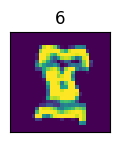

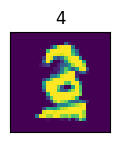

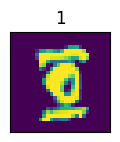

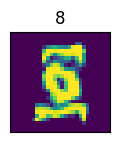

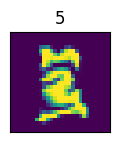

In [ ]:
plot_example(X_test[error_mask], y_pred[error_mask])

In [ ]:
[mnist_dim//4, mnist_dim//2]

[196, 392]

In [ ]:
hidden_dims = [50, 50]
net4 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net4.fit(X_train, y_train);
nets.append(net4)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7779       0.9683        0.1056  1.1830
      2        0.1783       0.9842        0.0511  1.1221
      3        0.1289       0.9862        0.0407  1.2983
      4        0.1088       0.9880        0.0348  1.5614
      5        0.0931       0.9884        0.0331  1.2336
      6        0.0828       0.9897        0.0294  1.1648
      7        0.0777       0.9894        0.0304  1.1304
      8        0.0733       0.9902        0.0290  1.1371
      9        0.0694       0.9915        0.0238  1.1538
     10        0.0619       0.9918        0.0252  1.1127
     11        0.0612       0.9915        0.0256  1.1115
     12        0.0564       0.9916        0.0230  1.1172
     13        0.0534       0.9918        0.0245  1.1215
     14        0.0510       0.9922        0.0231  1.5822
     15        0.0512       0.9929        0.0209  1.3470
     16        0.0483       0.9

In [ ]:
y_pred = net4.predict(X_test)
accuracy_score(y_test, y_pred)

0.9922

In [ ]:
y_pred = net4.predict(attacked)
accuracy_score(y_test, y_pred)

0.4498

In [ ]:
hidden_dims = [20, 20, 20, 20, 20]
net5 = NeuralNetClassifier(ClassifierModule(mnist_dim, hidden_dims, output_dim), max_epochs=20, lr=0.1, device=device)
net5.fit(X_train, y_train);
nets.append(net5)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.3037       0.1000        2.3019  1.3276
      2        2.2963       0.2223        2.2433  1.2740
      3        1.9247       0.3468        1.6578  1.5415
      4        1.4918       0.6458        1.1775  1.8502
      5        1.1341       0.7750        0.7242  1.3563
      6        0.8528       0.8393        0.5785  1.3005
      7        0.7531       0.8874        0.4561  1.2825
      8        1.9126       0.4859        1.3605  1.2869
      9        1.5046       0.7798        1.0384  1.3280
     10        1.0029       0.9253        0.4436  1.3009
     11        0.7570       0.7752        0.6007  1.3166
     12        0.6738       0.9742        0.2430  1.5911
     13        0.6555       0.9778        0.2306  1.7554
     14        0.6087       0.9755        0.2126  1.2669
     15        0.5927       0.9798        0.2028  1.2737
     16        0.6040       0.9

In [ ]:
y_pred = net5.predict(X_test)
accuracy_score(y_test, y_pred)

0.9853

In [ ]:
y_pred = net5.predict(attacked)
accuracy_score(y_test, y_pred)

0.403

In [ ]:
def get_correlation(module1, module2, X):
  Ts1, layers1 = module1.forward(X, eval=True)[1], module1.forward(X, eval=True)[2]
  Ts2, layers2 = module2.forward(X, eval=True)[1], module2.forward(X, eval=True)[2]

  correlations = np.zeros_like(Ts1.cpu().detach().numpy()[0])
  for i in range(Ts1.shape[1]):
    neuron_i = Ts1[:, i]
    max_idx = 0
    max_corr = -1
    for j in range(Ts2.shape[1]):
      neuron_j = Ts2[:, j]
      stacked = torch.stack((neuron_i, neuron_j))
      corr = torch.corrcoef(stacked)[0, 1] / (abs(layers1[0, i] - layers2[0, j]) + 1)
      corr = corr.cpu().detach().numpy()
      if corr > max_corr:
        max_corr = corr
        max_idx = j
    correlations[i] = max_corr

  return correlations.mean()

def mean_correlation(module1, module2, X):
    return (get_correlation(module1, module2, X) + get_correlation(module2, module1, X)) / 2

# Convolutional Network


In [ ]:
# XCnn_train, XCnn_test, y_train, y_test = train_test_split(XCnn, y, test_size=0.25, random_state=42)

In [ ]:
# XCnn_train.shape, y_train.shape

In [ ]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x, eval=False):

        outputs = []
        x = x.reshape((x.shape[0], 1, 28, 28))

        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        outputs.append(x)
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        outputs.append(x)

        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))

        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)

        Ts = None
        layers = None
        layer_num = 0
        if eval:
          for X in outputs:
            X = X.reshape((X.shape[0], np.prod(X.shape) // X.shape[0]))
            Ts = torch.cat((Ts, X), 1) if Ts is not None else X
            l = torch.ones_like(X) * layer_num
            layers = torch.cat((layers, l), 1) if layers is not None else l
            layer_num += 1
          return x, Ts, layers

        return x


In [ ]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn(),
    max_epochs=10,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

In [ ]:
cnn.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3426       0.9981        0.0072  2.3480
      2        0.0374       0.9991        0.0034  1.8995
      3        0.0246       0.9991        0.0028  1.8014
      4        0.0164       0.9999        0.0004  1.8556
      5        0.0142       0.9998        0.0007  1.8834
      6        0.0147       0.9998        0.0004  1.7867
      7        0.0125       0.9997        0.0010  1.9996
      8        0.0103       0.9998        0.0004  2.1244
      9        0.0098       0.9998        0.0003  1.8095
     10        0.0105       0.9997        0.0010  1.7996


In [ ]:
y_pred = cnn.predict(X_test)
accuracy_score(y_test, y_pred)

0.9998

In [ ]:
y_pred = cnn.predict(attacked)
accuracy_score(y_test, y_pred)

0.2712

In [ ]:
X_test.shape

(10000, 784)

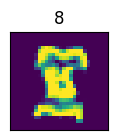

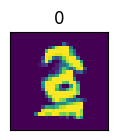

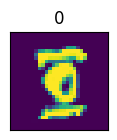

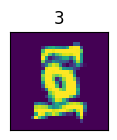

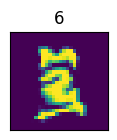

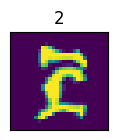

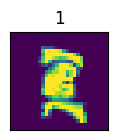

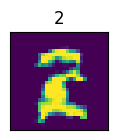

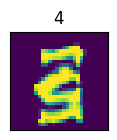

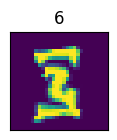

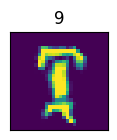

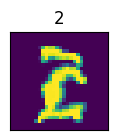

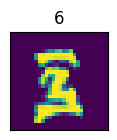

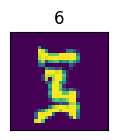

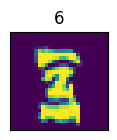

In [ ]:
plot_example(X_test, y_test, n=15)

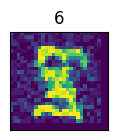

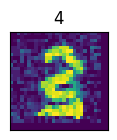

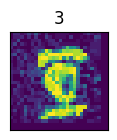

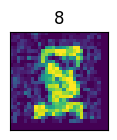

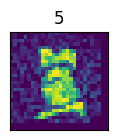

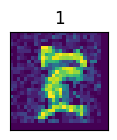

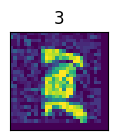

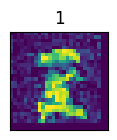

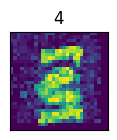

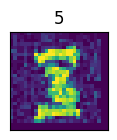

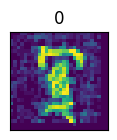

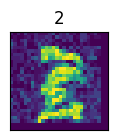

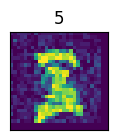

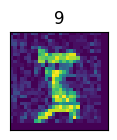

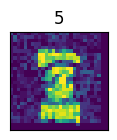

In [ ]:
plot_example(attacked, y_pred, n=15)